### PyTorch官方參考範例
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import os
import glob
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import time
from PIL import Image

def CCSN_images(dataset_dir):
    classfolder = glob.glob(os.path.join(dataset_dir,"*"),recursive=True)
    class_name  = [f.split(os.path.sep)[-1] for f in classfolder]
    img_labels  = []
    img_list    = []

    for class_id, f in enumerate(classfolder):
        files = glob.glob(os.path.join(f,"*.jpg"),recursive=True)
        img_labels.extend([class_id]*len(files))
        img_list.extend(files)

    img_labels = np.array(img_labels)
    img_list   = np.array(img_list,dtype=object)

    return img_list.reshape((-1,1)), img_labels, class_name

### 定義Dataset

In [2]:
class CCSNImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, img_labels, transform=None, target_transform=None):
        self.transform        = transform
        self.target_transform = target_transform
        self.img_list         = img_list
        self.img_labels       = img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_list[idx,0]
        image    = Image.open(img_path)
        label    = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


### 設定CCSN資料集路徑
例如:
![image.png](attachment:image.png)

In [3]:


CCSNDataset_Path = "CCSN_v2"
img_list, img_labels, label_names = CCSN_images(CCSNDataset_Path)

CCSNDataset = CCSNImageDataset(img_list,img_labels)

### 範例:透過Dataset載入並顯示部分資料集

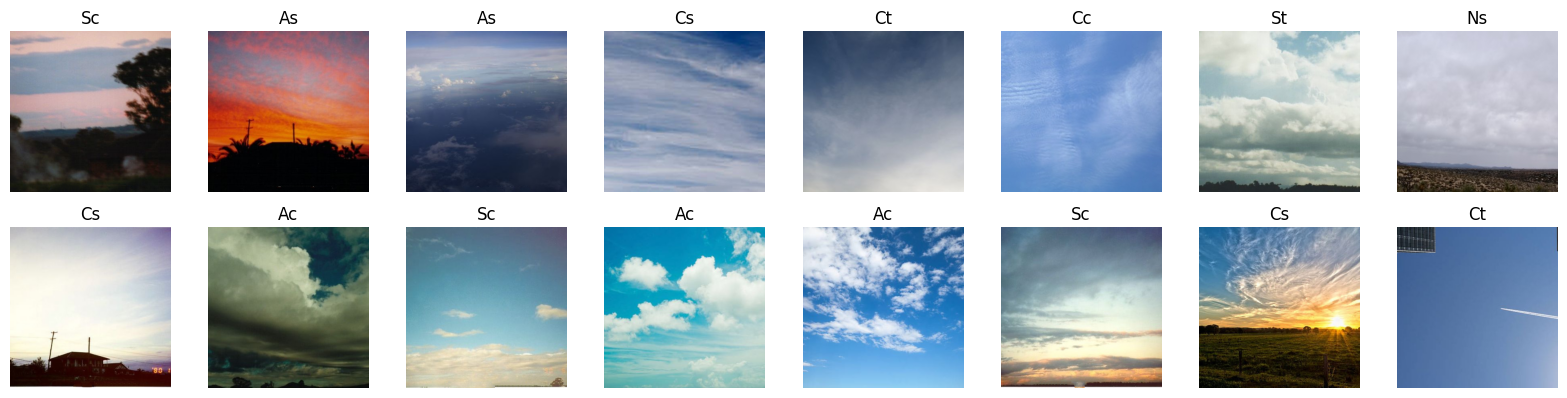

In [4]:
N = len(CCSNDataset)

plt.figure(figsize=(16,8))

for i in range(16):
    plt.subplot(4,8,i+1)
    image, label = CCSNDataset[np.random.randint(0,N)]
    plt.imshow(image)
    plt.title(label_names[label])
    plt.axis(False)
plt.tight_layout()
plt.show()

### 使用預訓練模型
列出torchvision.models裡內建預訓練模型。

In [5]:
import torchvision
dir(torchvision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [6]:
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25, patience = 0,scheduler = None):

    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = None
        best_acc  = 0
        history = {'loss':[],'accuracy':[],'val_loss':[],'val_accuracy':[]}
        patience_c = 0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch:3d}/{num_epochs - 1}',end=' ')

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train' and scheduler:
                    scheduler.step(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}',end=' ' if phase=='train' else '\n')
                if phase == 'train':
                    history['loss'].append(epoch_loss)
                    history['accuracy'].append(epoch_acc.cpu().numpy())

                # deep copy the model
                if phase == 'val':
                    history['val_loss'].append(epoch_loss)
                    history['val_accuracy'].append(epoch_acc.cpu().numpy())
                    if best_acc < epoch_acc.cpu().numpy():
                        best_acc = epoch_acc.cpu().numpy()
                    if epoch == 0 or epoch_loss < best_loss:
                        best_loss = epoch_loss
                        patience_c= 0
                        torch.save(model.state_dict(), best_model_params_path)
                    else:
                        patience_c += 1

            if patience_c > patience:
                break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, history

def evaluate(model, dataloader):

    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    dataset_size     = 0
        # Iterate over data.
    for inputs, labels in dataloader:

        dataset_size += inputs.size(0)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    print(f'test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc.cpu().numpy()

### MyClassifierModel

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        
        self.cnn_layers = nn.Sequential(
            # 3 * 224 * 224 -> 64 * 111 * 111
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 64 * 111 * 111 -> 128 * 54 * 54
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 128 * 54 * 54 -> 256 * 26 * 26
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        #self-attention layer
        self.self_attn = nn.MultiheadAttention(embed_dim=256, num_heads=8, batch_first=True)

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 11),
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # output -> [batch_size, 256 ,26 ,26] -> [batch_size, 512, 26*26] -> [batch_size, 26*26, 512]
        x = x.view(x.size(0), 256, -1).permute(0, 2, 1)  

        # output -> [batch_size, 26*26, 256]
        x, _ = self.self_attn(x, x, x)

        # global average pooling,output -> [batch_size, 256]
        x = x.mean(dim=1)  

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [8]:
from sklearn.model_selection import StratifiedKFold

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('gpu is available')
else:
    print('cpu only')

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

skf        = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # 80 % for training and validation sets, 20 % for the test set

batch_size = 64
epochs     = 100
patience   = epochs//5

test_accuracy = []
test_loss     = []
histories     = []

criterion = nn.CrossEntropyLoss()

for i, (train_idx, test_idx) in enumerate(skf.split(img_list,img_labels)):

    print('-'*50)

    X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(img_list[train_idx],img_labels[train_idx],test_size=0.2,random_state=i)

    testloader = torch.utils.data.DataLoader(CCSNImageDataset(img_list[test_idx],img_labels[test_idx],data_transforms['train'],lambda x : torch.tensor(x,dtype=torch.long)),batch_size=1,shuffle=True)
    trainloader= torch.utils.data.DataLoader(CCSNImageDataset(X_train,y_train,data_transforms['train'],lambda x : torch.tensor(x,dtype=torch.long)),batch_size=batch_size,shuffle=True)
    validloader= torch.utils.data.DataLoader(CCSNImageDataset(X_valid,y_valid,data_transforms['val'],lambda x : torch.tensor(x,dtype=torch.long)),batch_size=batch_size,shuffle=True)

    classifier = Classifier()
    for name, param in classifier.self_attn.named_parameters():
        param.requires_grad = False
    for name, param in classifier.named_parameters():
        print(name, param.requires_grad)
    classifier = classifier.to(device)
    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3)

    trained_model, history = train_model(classifier, criterion, optimizer_ft,
                                         dataloaders={'train':trainloader,'val':validloader},
                                         dataset_sizes={'train':X_train.shape[0],'val':X_valid.shape[0]},
                                         patience=patience,
                                         num_epochs=epochs,
                                         scheduler = scheduler)

    histories.append(history)
    print(f'Fold {i+1:2d}',end=' ')
    loss, acc = evaluate(trained_model, testloader)

    test_loss.append(loss)
    test_accuracy.append(acc)

gpu is available
--------------------------------------------------
cnn_layers.0.weight True
cnn_layers.0.bias True
cnn_layers.1.weight True
cnn_layers.1.bias True
cnn_layers.3.weight True
cnn_layers.3.bias True
cnn_layers.4.weight True
cnn_layers.4.bias True
cnn_layers.7.weight True
cnn_layers.7.bias True
cnn_layers.8.weight True
cnn_layers.8.bias True
cnn_layers.11.weight True
cnn_layers.11.bias True
cnn_layers.12.weight True
cnn_layers.12.bias True
self_attn.in_proj_weight False
self_attn.in_proj_bias False
self_attn.out_proj.weight False
self_attn.out_proj.bias False
fc_layers.0.weight True
fc_layers.0.bias True
fc_layers.2.weight True
fc_layers.2.bias True
fc_layers.4.weight True
fc_layers.4.bias True
Epoch   0/99 train Loss: 2.4206 Acc: 0.1530 val Loss: 2.2221 Acc: 0.2482
Epoch   1/99 train Loss: 2.2645 Acc: 0.2237 val Loss: 2.1871 Acc: 0.2973
Epoch   2/99 train Loss: 2.2669 Acc: 0.2194 val Loss: 2.1015 Acc: 0.2850
Epoch   3/99 train Loss: 2.1805 Acc: 0.2274 val Loss: 2.0166 Acc:

In [9]:
print(classifier)

Classifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (self_attn): Multihea

### 顯示結果

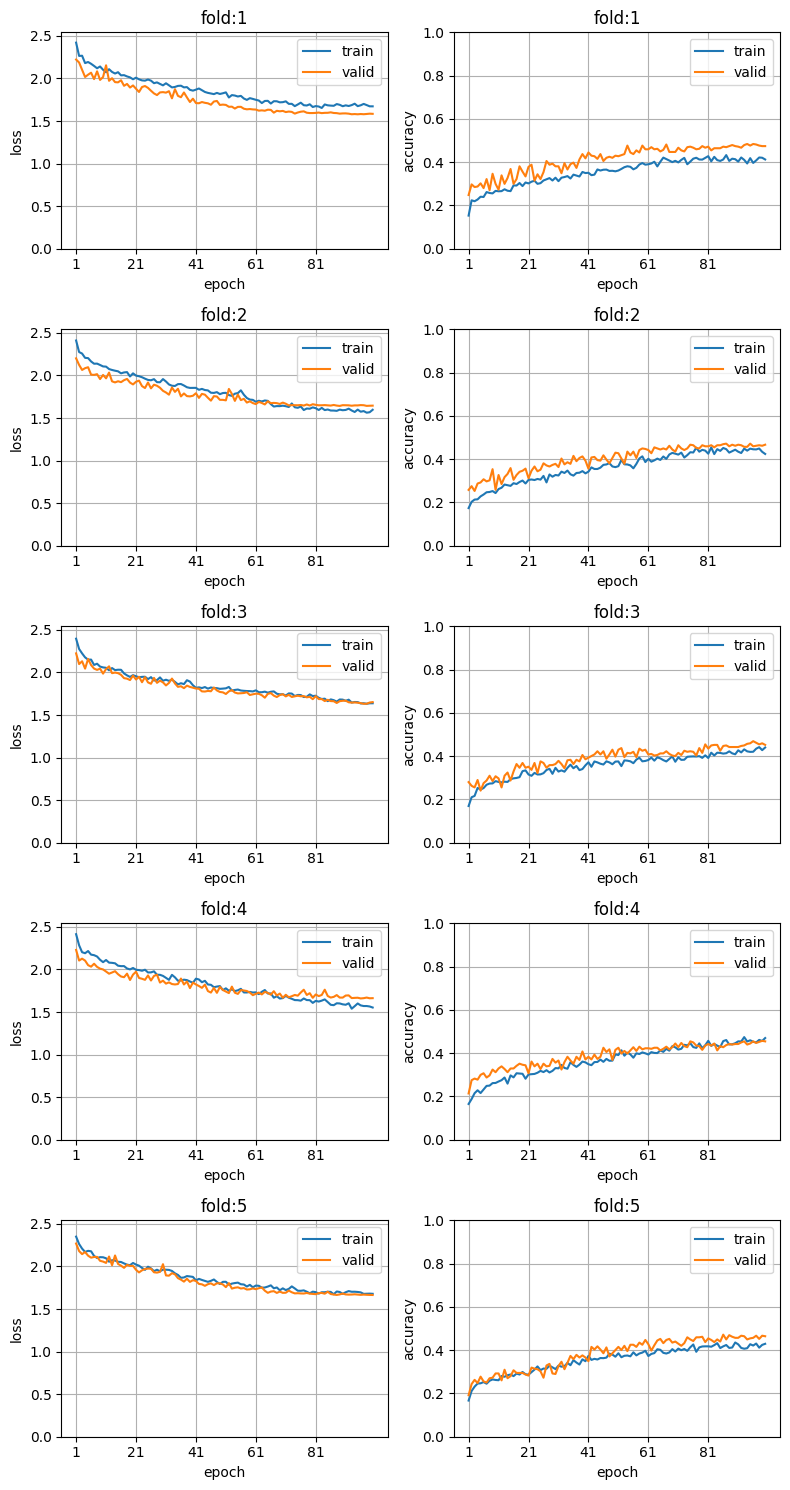

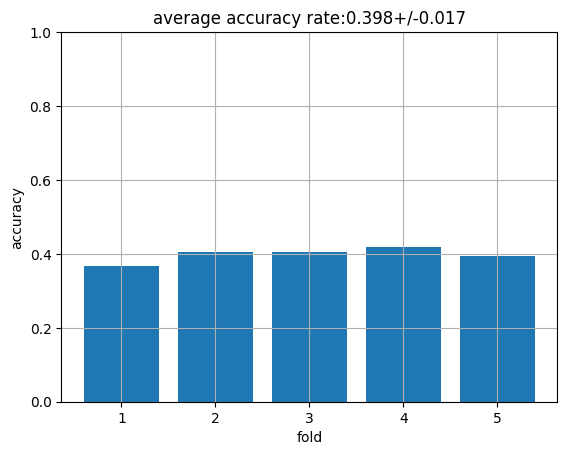

average accuracy rate:0.398+/-0.017


In [10]:
plt.figure(figsize=(8,3*len(histories)))

max_loss = 0
max_acc  = 0
for i,history in enumerate(histories):
    max_loss = max(max_loss,np.max(history['loss']),np.max(history['val_loss']))

max_loss *= 1.05
for i,history in enumerate(histories):
    plt.subplot(len(histories),2,i*2+1)
    plt.title(f'fold:{i+1}')
    plt.plot(history['loss'],label='train')
    plt.plot(history['val_loss'],label='valid')
    plt.xlabel('epoch')
    step = int(np.ceil(len(history['loss'])/5))
    plt.xticks(np.arange(0,len(history['loss']),step),[str(u+1) for u in np.arange(0,len(history['loss']),step)])
    plt.ylabel('loss')
    plt.ylim([0,max_loss])
    plt.grid(True)
    plt.legend()

    plt.subplot(len(histories),2,i*2+2)
    plt.title(f'fold:{i+1}')
    plt.plot(history['accuracy'],label='train')
    plt.plot(history['val_accuracy'],label='valid')
    plt.xticks(np.arange(0,len(history['accuracy']),step),[str(u+1) for u in np.arange(0,len(history['accuracy']),step)])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim([0,1.0])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.bar(x=np.arange(len(test_accuracy)),height=np.array(test_accuracy))
plt.xlabel('fold')
plt.xticks(np.arange(len(test_accuracy)),[str(i+1) for i in np.arange(len(test_accuracy))])
plt.ylabel('accuracy')
plt.title(f'average accuracy rate:{np.mean(np.array(test_accuracy)):.3f}+/-{np.std(np.array(test_accuracy)):.3f}')
plt.grid(True)
plt.ylim([0,1.0])
plt.show()
print(f'average accuracy rate:{np.mean(np.array(test_accuracy)):.3f}+/-{np.std(np.array(test_accuracy)):.3f}')